# Dog Breed Classificiation

---

## Introduction

Develop an algorithm that could be used as part of a mobile or web app. The code can accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling. The image below displays potential sample output of our finished project. 

![Sample Dog Output](images/sample_dog_output.png)

We will need to piece together a series of models to perform different tasks: an algorithm to detect humans in an image, and another which uses CNN & Transfer Learning to infer dog breed. We will put them together to finish the pipeline!

We break the notebook into separate steps:

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (Using VGG-16)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (Using ResNet-50)
* [Step 6](#step6): Complete the Pipeline
* [Step 7](#step7): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    """Take in a path and load the data."""
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


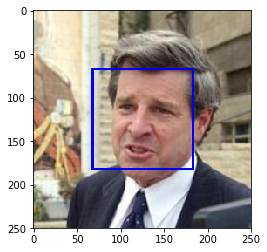

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
def face_detector(img_path):
    """Return 'True' if face is detected in image stored at img_path."""
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

We will use the code cell below to test the performance of the `face_detector` function. Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. We will see that our algorithm falls short of this goal, but still gives acceptable performance. We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.
- 100% of the first 100 images in `human_files` have a detected human face. 
- 11% of the first 100 images in `dog_files` have a detected human face.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Test the performance of the face_detector algorithm 
# on the images in human_files_short and dog_files_short.
num_faces_detected = 0
for img in human_files_short:
    if face_detector(img):
        num_faces_detected += 1

print ("Percentage of human faces detected from human_files: %.0f%%" % num_faces_detected )

num_faces_detected = 0        
for img in dog_files_short:
    if face_detector(img):
        num_faces_detected += 1

print ("Percentage of human faces detected from dog_files: %.0f%%" % num_faces_detected )

Percentage of human faces detected from human_files: 100%
Percentage of human faces detected from dog_files: 11%


This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In my opinion, however, it is not really a reasonable expectation to pose on the user for a few reasons. It's important for apps to be user-friendly so we shouldn't force users to provide only clear photos. We can train a neural network to recognize a human face from an image that doesn't show the face clearly. Based on the ideas in [this article](https://www.wired.com/2016/09/machine-learning-can-identify-pixelated-faces-researchers-show/), we can manipulate images (e.g. blurring the faces on the images, increasing/decreasing the brightness of the images, etc.) and train a neural network to recognize that those are human faces.

In this project, we will use the face detector from OpenCV to detect human images in our algorithm.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in our dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    """Take a string-valued file path to a color image as input and 
    return a 4D tensor suitable for supplying to a Keras CNN."""
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """Take a numpy array of string-valued image paths as input and 
    return a 4D tensor with shape (nb_samples, 224 , 224, 3)."""
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`, whose code is available [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    """Return prediction vector for image located at img_path"""
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`. Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
def dog_detector(img_path):
    """Return 'True' if a dog is detected in the image stored at img_path."""
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

The code cell below tests the performance of our `dog_detector` function.
- None of the images in `human_files_short` have a detected dog
- 100% of the images in `dog_files_short` have a detected dog

In [11]:
# Test the performance of the dog_detector function
# on the images in human_files_short and dog_files_short.

num_dogs_detected = 0
for img in human_files_short:
    if dog_detector(img):
        num_dogs_detected += 1

print ("Percentage of the images in human_files_short have a detected dog: %.0f%%" % num_dogs_detected )

num_dogs_detected = 0        
for img in dog_files_short:
    if dog_detector(img):
        num_dogs_detected += 1

print ("Percentage of the images in dog_files_short have a detected dog: %.0f%%" % num_dogs_detected )

Percentage of the images in human_files_short have a detected dog: 0%
Percentage of the images in dog_files_short have a detected dog: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds. we will create a CNN _from scratch_.  In Step 5 of this notebook, we will use transfer learning to create a CNN that attains greatly improved accuracy.

The task of assigning breed to dogs from images is considered exceptionally challenging. To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

Likewise, labradors come in yellow, chocolate, and black.  Our vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 183.25it/s]


### Model Architecture

Below are the steps I took to reach the final CNN architecture:

1. I started out with the below architecture:

```python
    model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', 
              input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(GlobalAveragePooling2D(input_shape=train_tensors.shape[1:]))
    model.add(Dense(133, activation='softmax'))
```
    I ran it for 5 epochs. The test accuracy was very low, only around 3%. Therefore I decided not to use this model.

2. Then I removed `GlobalAveragePooling2D`, added `Dropout` layers and one more `Dense` layer, and changed padding to `same`. 

    The sequence of three convolutional layers, each followed by a MaxPooling layer, extracts all spatial information about the image. The final two dense layers further clarifies the content of the image.

    Changing padding to `same` means that each convo layer pads the input such that the output has the same length as the original input. According to [this](https://stats.stackexchange.com/questions/246512/convolutional-layers-to-pad-or-not-to-pad), using padding is important for a few reasons, including "improving performance by keeping information at the borders".

    ```python
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(133, activation='softmax'))
    ```

    I ran this model for 5 epochs. This model yielded a better accuracy rate of 8%.

3. I tweaked the model in step 2 by increasing the last Dropout to 0.5 and the accuracy rate increased to 11%. The increased Dropout must have reduced overfitting. I also tried adding another Dropout after the 1st and the 2nd MaxPooling layer but this didn't improve the performance. 

4. I kept the last Dropout at 0.5 and increased both the kernel_size and pool_size from 2 to 4 and the number of epochs to 10. The test accuracy increased to 13.4%

5. I kept the changes made in step 4, and ran the updated model for 30 epochs. The final model can be seen in the code below. I used EarlyStopping and the training process stopped after epoch 16. The test accuracy rate jumped to 15.6%. 

6. Finally, I used [image augmentation technique](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) and ran the final model from the previous step for 100 epochs. I also used EarlyStopping and the training terminated after 15 epochs. The test accuracy rate improved to 16.5%.

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=4, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=4))
model.add(Conv2D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=4))
model.add(Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      784       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 64)          0         
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

We will train the final model and use model checkpointing to save the model that attains the best validation loss.

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping 


# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)

batch_size = 20
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0)
model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=0, callbacks=[checkpointer, early_stopping],
                    validation_data=(valid_tensors, valid_targets))

Epoch 00000: val_loss improved from inf to 4.79861, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00001: val_loss improved from 4.79861 to 4.60500, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00002: val_loss improved from 4.60500 to 4.35897, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00003: val_loss improved from 4.35897 to 4.14587, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00004: val_loss improved from 4.14587 to 4.05755, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00005: val_loss improved from 4.05755 to 4.04451, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00006: val_loss improved from 4.04451 to 3.92557, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00007: val_loss improved from 3.92557 to 3.82631, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss improved from 3.

### Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Let's try out our model on the test dataset of dog images.

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# get index of predicted dog breed for each image in training set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in train_tensors]

# report training accuracy
train_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(train_targets, axis=1))/len(dog_breed_predictions)
print('Training accuracy: %.4f%%' % train_accuracy)

# get index of predicted dog breed for each image in validation set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report validation accuracy
valid_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(valid_targets, axis=1))/len(dog_breed_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Test accuracy: 16.5072%
Training accuracy: 22.0509%
Validation accuracy: 14.1317%


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (Using VGG-16)

To reduce training time without sacrificing accuracy, we will train a CNN using transfer learning.

### Obtain Bottleneck Features

In [19]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [20]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [21]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.3676 - acc: 0.1151 - val_loss: 10.8890 - val_acc: 0.2048
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.1749 - acc: 0.2738 - val_loss: 10.2810 - val_acc: 0.2695
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.6463 - acc: 0.3391 - val_loss: 10.0520 - val_acc: 0.2922
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.3229 - acc: 0.3707 - val_loss: 9.7363 - val_acc: 0.3054
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.1065 - acc: 0.3967 - val_loss: 9.7294 - val_acc: 0.3150
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 8.8804 - acc: 0.4154 - val_loss: 9.3971 - val_acc: 0.3365
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.7309 - acc: 0.4349 - val_loss: 9.3260 - val_acc: 0.3509
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.6259

### Load the Model with the Best Validation Loss

In [23]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [24]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 40.9091%


### Predict Dog Breed with the Model

In [25]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    """Take a path to an image as input and return the dog breed 
    that is predicted by the model.
    """
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features. In this section, we will use the bottleneck features from a different pre-trained model. Below are links where we can download the pre-computed features for four networks:

- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`. In this section we will use ResNet-50. We will download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

The code block below extracts the bottleneck features corresponding to the train, test, and validation sets:

In [26]:
# Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

## Model Architecture

We will create another CNN to classify dog breed. This time, we will use ResNet-50. Here are the steps to get the final model:

1. I initially tried the following architecture which yielded an accuracy rate of 78%:

```python
    model = Sequential()
    model.add(Flatten(input_shape=train_Resnet50.shape[1:]))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(133, activation='softmax'))
```

2. I then replaced the first `Dense` layer with a `GlobalAveragePooling2D` layer. The accuracy improved to 81%.

```python
    Resnet50_model = Sequential()
    Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
    Resnet50_model.add(Dense(133, activation='softmax'))
```
    The chosen architecture was faster to run as the `GlobalAveragePooling2D` layer reduces dimensionalities more significantly than the `Dense(500...)` layer.

In summary, the model worked because the dog dataset is relatively small and has significant overlap with a subset of the ImageNet categories. The weights and pre-trained network were kept fixed. Only an input layer, the global average pooling layer, and an output layer, the fully connected layer, were added.

In the following cells, we will outline the final model architecture and training process.

In [27]:
# Define our architecture
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [28]:
# Compile the model
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

We will train our model and use model checkpointing to save the model that attains the best validation loss.  

In [29]:
# Train the model
from keras.callbacks import ModelCheckpoint, EarlyStopping 

early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0)
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer, early_stopping], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 1.6211 - acc: 0.5976 - val_loss: 0.8673 - val_acc: 0.7305
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 0.4457 - acc: 0.8612 - val_loss: 0.7878 - val_acc: 0.7593
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 0.2667 - acc: 0.9144 - val_loss: 0.6928 - val_acc: 0.7928
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 0.1782 - acc: 0.9415 - val_loss: 0.6931 - val_acc: 0.7940
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 0.1197 - acc: 0.9639 - val_loss: 0.6883 - val_acc: 0.8036
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 0.0862 - acc: 0.9740 - val_loss: 0.6747 - val_acc: 0.8072
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 0.0634 - acc: 0.9826 - val_loss: 0.7168 - val_acc: 0.8204
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 0.0491 - ac

### Load the Model with the Best Validation Loss

In [30]:
# Load the model weights with the best validation loss
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

We'll test the model on the test dataset of dog images.

In [31]:
# Get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# Report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.7416%


### Predict Dog Breed with the Model

We will now implement a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model.  

Similar to the analogous function in Step 5, our function will:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.

In [32]:
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    """Take a path to an image as input and return the dog breed 
    that is predicted by the model.
    """
    # Extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # Obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # Return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Complete the Pipeline

Now, we will put things together and write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither. Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [33]:
def predict_dog_breed(img_path):
    # Load image from the given path
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()    
    if dog_detector(img_path):
        print (Resnet50_predict_breed(img_path))
    elif face_detector(img_path):
        print ("This looks like a human. If this person were a dog, they would look like a/an", Resnet50_predict_breed(img_path))
    else:
        print ("Not sure whom you are")

---
<a id='step7'></a>
## Step 7: Test the Algorithm

### Test the Algorithm on Sample Images

We will test our algorithm on a few images.

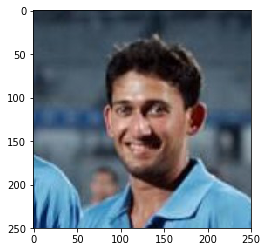

This looks like a human. If this person were a dog, they would look like a/an Silky_terrier


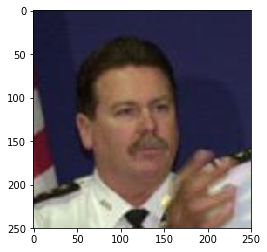

This looks like a human. If this person were a dog, they would look like a/an Japanese_chin


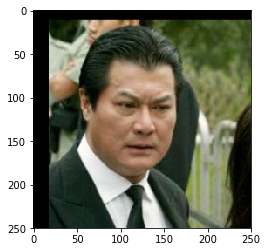

This looks like a human. If this person were a dog, they would look like a/an English_toy_spaniel


In [34]:
# Test the algorithm on human images and return a corresponding dog breed
predict_dog_breed("test_images/Ajit_Agarkar_0001.jpg")
predict_dog_breed("test_images/Alan_Dreher_0001.jpg")
predict_dog_breed("test_images/Alan_Tang_Kwong-wing_0001.jpg")


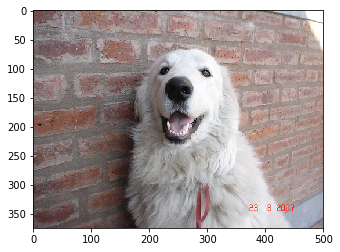

Kuvasz


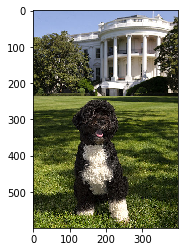

Not sure whom you are


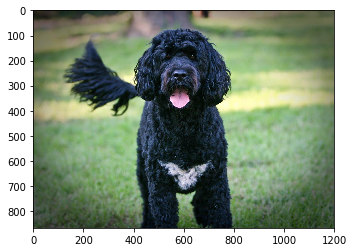

Black_russian_terrier


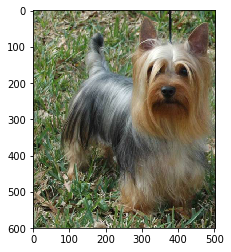

Silky_terrier


In [35]:
# Test the algorithm on dog images
predict_dog_breed("test_images/Kuvasz_06388.jpg")
predict_dog_breed("test_images/Portuguese_water_dog_07963.jpg")
predict_dog_breed("test_images/Portuguese_water_dog_07975.jpg")
predict_dog_breed("test_images/Silky_terrier_08040.jpg")


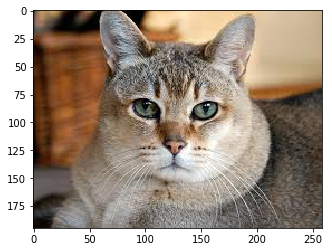

Not sure whom you are


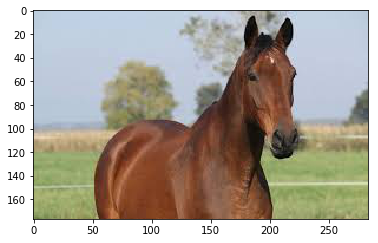

Not sure whom you are


In [36]:
# Test the algorithm on neither human nor dog images
predict_dog_breed("test_images/cat.jpg")
predict_dog_breed("test_images/horse.jpg")

As seen above, the output is relatively ok. However, there are some mistakes. As a next step, we propose improving the algorithm as follows:
- Apply image augmentation, which may help in the case of `Portuguese_water_dog_07963.jpg`
- Fine-tune the last convolutional block, before adding the top fully-connected model, as suggested in the final section of [this post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). This may help distinguish breeds that look similar to each other, such as Portuguese water dogs and Black Russian terriers.
- While all of the below test images of humans are correctly identified by the algorithm, it may not always be the case. We can try using another method to detect faces. We could use Resnet-50 or VGG-19, etc. to detect human faces instead.